# Data Preprocessing

Make the data pipeline from raw tables to create analytical datasets.

At the end, train & test data sets are created from raw data.

## Imports, Configuration, and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
import os
import os.path as op
import shutil
import warnings
from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
from scripts import *
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import ta_lib.eda.api as eda
from ta_lib.core.api import (create_context, custom_train_test_split,
                             display_as_tabs, get_dataframe,
                             get_feature_names_from_column_transformer,
                             get_package_path, initialize_environment,
                             list_datasets, load_dataset, merge_info,
                             save_dataset, setanalyse, string_cleaning)


pd.options.mode.use_inf_as_na = True
warnings.filterwarnings(
    'ignore',
    message="The default value of regex will change from True to False in a \
future version.",
    category=FutureWarning
)

In [3]:
initialize_environment(debug=False, hide_warnings=True)

## 0. Initialization

In [4]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
pprint(list_datasets(context))

['/raw/google_search',
 '/raw/product_manufacturer',
 '/raw/sales',
 '/raw/social_media',
 '/raw/theme',
 '/raw/theme_product',
 '/cleaned/google_search',
 '/cleaned/product_manufacturer',
 '/cleaned/sales',
 '/cleaned/social_media',
 '/cleaned/theme',
 '/cleaned/theme_product',
 '/cleaned/final_cleaned_merged_data',
 '/processed/sales',
 '/train/sales/features',
 '/train/sales/target',
 '/test/sales/features',
 '/test/sales/target',
 '/score/sales/output']


## 1. Data Cleaning and Consolidation

**<u>NOTES</u>**

The focus here is to create a cleaned dataset that is appropriate for solving the DS problem at hand from the raw data.

**1. Do**
* Clean dataframe column names
* Ensure data-types are set properly
* Join with other tables, etc. to create features
* Transform, if appropriate, datetime like columns to generate additional features (such as weekday)
* Transform, if appropriate, string columns to generate additional features
* Discard columns that are not useful for training the model (IDs, constant cols, duplicate cols etc)
* Additional features generated from existing columns


**2. Don't**
* Handle missing values or outliers here. Mark them and leave them for processing downstream.

### 1.1 Clean Individual Tables

**NOTE:** This will go into production code.

In [5]:
# Load raw datasets in a loop
data = dict()

for dataset in list_datasets(context):
    if '/raw/' in dataset:
        dataset_name = dataset.replace('/raw/', '')
        key_ = dataset_name + '_df'
        data[key_] = load_dataset(context, dataset)
        
        # Standardize and clean column names
        data[key_].columns = string_cleaning(data[key_].columns, lower=True)
        if key_ == "google_search_df":
            data[key_].rename(columns={
                "searchvolume": "search_volume",
                "claim_id": "theme_id",
            }, inplace=True)
        if key_ == "product_manufacturer_df":
            cols_2_drop = [f"unnamed {i}" for i in range(2, 7)]
            data[key_].drop(columns=cols_2_drop, axis=1, inplace=True)
        if key_ == "social_media_df":
            data[key_].rename(columns={"theme id": "theme_id",}, inplace=True)
        if key_ == "theme_df":
            data[key_].rename(columns={
                "claim_id": "theme_id",
                "claim name": "theme_name",
            }, inplace=True)
        if key_ == "theme_product_df":
            data[key_].rename(columns={"claim_id": "theme_id",}, inplace=True)
            
        
        # Drop duplicates
        data[key_].drop_duplicates(inplace=True)
        
        # Save processed data
        save_dataset(context, data[key_], 'cleaned/' + dataset_name)

In [6]:
# Check the variable summaries after the data cleaning
summaries = [eda.get_variable_summary(data[key]) for key in data.keys()]

display_as_tabs([(key, summaries[idx]) for idx, key in enumerate(data.keys())])

Tabs
    [0] DataFrame(height=300, name='google_search_df', sizing_mode='fixed', value=               Variable Na..., width=800)
    [1] DataFrame(height=300, name='product_manufacturer_df', sizing_mode='fixed', value=           Variable Name D..., width=800)
    [2] DataFrame(height=300, name='sales_df', sizing_mode='fixed', value=                          ..., width=800)
    [3] DataFrame(height=300, name='social_media_df', sizing_mode='fixed', value=                 Variable ..., width=800)
    [4] DataFrame(height=300, name='theme_df', sizing_mode='fixed', value=           Variable Name D..., width=800)
    [5] DataFrame(height=300, name='theme_product_df', sizing_mode='fixed', value=           Variable Name D..., width=800)

### **EDA

We are doing some EDA here as these required the data to be cleaned first.

First, merge `sales_df` and `theme_product_df` to get the corresponding theme id for each product id in `sales_df`.

In [7]:
sales_df = data["sales_df"]
theme_product_df = data["theme_product_df"]

setanalyse(sales_df.product_id.to_list(), theme_product_df.product_id.to_list())

{'A-B': 0, 'B-A': 14701, 'AuB': 57317, 'A^B': 42616}

In [8]:
sales_with_theme = pd.merge(sales_df, theme_product_df, "left", "product_id")

sales_with_theme.sample(6, random_state=context.random_seed)

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id
466375,20160409,42506,678.0,68,21,81
3730689,20171202,46836,2425.0,193,772,186
6731893,20190413,52456,119.0,17,42,186
2021095,20170204,8364,2523.0,48,1442,227
316193,20160312,18940,4691.0,253,1137,81
7170312,20190629,34551,909.0,699,44,0


Now, based on the `theme_id`, get the theme name in the sales dataframe.

In [9]:
theme_df = data["theme_df"]

setanalyse(sales_with_theme.theme_id.to_list(), theme_df.theme_id.to_list())

{'A-B': 0, 'B-A': 159, 'AuB': 208, 'A^B': 49}

In [10]:
sales_with_theme = pd.merge(sales_with_theme, theme_df, "left", "theme_id")

sales_with_theme.sample(6, random_state=context.random_seed)

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name
466375,20160409,42506,678.0,68,21,81,gmo free
3730689,20171202,46836,2425.0,193,772,186,pollock
6731893,20190413,52456,119.0,17,42,186,pollock
2021095,20170204,8364,2523.0,48,1442,227,salmon
316193,20160312,18940,4691.0,253,1137,81,gmo free
7170312,20190629,34551,909.0,699,44,0,No Claim


List of themes in the sales data:

In [11]:
sales_with_theme.theme_name.nunique()

49

Now, let's merge the `google_search_df` with the `theme_df`.

In [12]:
google_search_df = data["google_search_df"]

setanalyse(google_search_df.theme_id.to_list(), theme_df.theme_id.to_list())

{'A-B': 0, 'B-A': 48, 'AuB': 208, 'A^B': 160}

In [13]:
google_search_df = pd.merge(google_search_df, theme_df, "left", "theme_id")

google_search_df.sample(6, random_state=context.random_seed)

,date,platform,search_volume,theme_id,week_number,year_new,theme_name
83716,2017-06-22,google,1575,583,25,2017,heart meat
40732,2015-11-27,google,510,622,48,2015,cheese
33179,2015-06-18,google,1052,519,25,2015,health (active)
48053,2016-07-09,google,50243,613,27,2016,sugar free
156297,2019-01-09,chewy,39,668,2,2019,probiotic
90438,2017-01-09,google,932,689,2,2017,vegetables


In [14]:
google_search_df.theme_name.nunique()

160

Next up is the merge of `social_media_df` and `theme_df`.

In [15]:
social_media_df = data["social_media_df"]
social_media_df.dropna(inplace=True)

setanalyse(social_media_df.theme_id.to_list(), theme_df.theme_id.to_list())

{'A-B': 0, 'B-A': 15, 'AuB': 208, 'A^B': 193}

In [16]:
social_media_df = pd.merge(social_media_df, theme_df, "left", "theme_id")

social_media_df.sample(6, random_state=context.random_seed)

,theme_id,published_date,total_post,theme_name
188720,438.0,10/18/2019,168,ethnic & exotic
181069,585.0,9/23/2015,0,garlic
115116,650.0,08-10-2016,6,added calcium
152991,606.0,8/22/2018,0,hemp seeds
159464,908.0,8/22/2018,19,sticks
234382,632.0,9/18/2015,0,pork


In [17]:
social_media_df.theme_name.nunique()

193

In [18]:
list_of_themes_across_all_dataset = list(
    set(sales_with_theme.theme_name.unique())
        | set(google_search_df.theme_name.unique())
        | set(social_media_df.theme_name.unique())
)

len(list_of_themes_across_all_dataset)

205

In [19]:
product_manufacturer_df = data["product_manufacturer_df"]

product_manufacturer_df.sample(6, random_state=context.random_seed)

,product_id,vendor
8220,8221,B
36375,36376,Others
49981,49982,Private Label
4599,4600,B
20806,20807,D
20562,20563,A


In [20]:
setanalyse(
    sales_with_theme.product_id.to_list(),
    product_manufacturer_df.product_id.to_list()
)

{'A-B': 0, 'B-A': 24559, 'AuB': 67175, 'A^B': 42616}

In [21]:
sales_with_vendor = pd.merge(
    sales_with_theme,
    product_manufacturer_df,
    "left",
    "product_id"
)

sales_with_vendor.sample(6, random_state=context.random_seed)

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,vendor
466375,20160409,42506,678.0,68,21,81,gmo free,Others
3730689,20171202,46836,2425.0,193,772,186,pollock,Private Label
6731893,20190413,52456,119.0,17,42,186,pollock,Private Label
2021095,20170204,8364,2523.0,48,1442,227,salmon,D
316193,20160312,18940,4691.0,253,1137,81,gmo free,F
7170312,20190629,34551,909.0,699,44,0,No Claim,Others


In [74]:
sales_with_vendor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7767420 entries, 0 to 7767419
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   product_id           int64         
 1   sales_dollars_value  float64       
 2   sales_units_value    int64         
 3   sales_lbs_value      int64         
 4   theme_id             int64         
 5   theme_name           object        
 6   vendor               object        
 7   purchase_date        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 533.3+ MB


#### Competitor Analysis

In [178]:
# Group by theme and aggregate total sales to find the total market per theme
total_sales_by_theme = (
    sales_with_vendor.groupby(['theme_id', 'theme_name'])
            ['sales_dollars_value']
            .sum()
            .reset_index()
)

total_sales_by_theme.rename(
    columns={'sales_dollars_value': 'total_sales_value'},
    inplace=True
)

total_sales_by_theme.head(2)

,theme_id,theme_name,total_sales_value
0,0,No Claim,5.876714e+10
1,8,low carb,1.862566e+10


In [179]:
# Group by theme and vendor and aggregate sales
vendor_sales = sales_with_vendor.groupby([
    'theme_id',
    'theme_name',
    'vendor'
])["sales_dollars_value"].sum().reset_index()

vendor_sales.head(3)

,theme_id,theme_name,vendor,sales_dollars_value
0,0,No Claim,A,2.352178e+10
1,0,No Claim,B,9.793774e+09
2,0,No Claim,D,7.385954e+09


In [180]:
# Merge the total sales for each theme
vendor_sales = pd.merge(
    vendor_sales,
    total_sales_by_theme,
    "left",
    ["theme_id", "theme_name"]
)

vendor_sales.head()

,theme_id,theme_name,vendor,sales_dollars_value,total_sales_value
0,0,No Claim,A,2.352178e+10,5.876714e+10
1,0,No Claim,B,9.793774e+09,5.876714e+10
2,0,No Claim,D,7.385954e+09,5.876714e+10
3,0,No Claim,E,1.939263e+09,5.876714e+10
4,0,No Claim,F,1.278799e+08,5.876714e+10


In [181]:
vendor_sales['market_share'] = (
    vendor_sales['sales_dollars_value'] / vendor_sales['total_sales_value']
)

vendor_sales.head()

,theme_id,theme_name,vendor,sales_dollars_value,total_sales_value,market_share
0,0,No Claim,A,2.352178e+10,5.876714e+10,0.400254
1,0,No Claim,B,9.793774e+09,5.876714e+10,0.166654
2,0,No Claim,D,7.385954e+09,5.876714e+10,0.125682
3,0,No Claim,E,1.939263e+09,5.876714e+10,0.032999
4,0,No Claim,F,1.278799e+08,5.876714e+10,0.002176


In [182]:
# Set a threshold for significant market share
threshold = 0.05  # 5% market share
significant_vendors = vendor_sales[
    (vendor_sales['market_share'] >= threshold)
        & (vendor_sales["vendor"] != "Others")  # not considering "Others"
        & (vendor_sales["theme_id"] != 0)  # not considering "No Claim" theme
]

significant_vendors.head()

,theme_id,theme_name,vendor,sales_dollars_value,total_sales_value,market_share
9,8,low carb,A,2.430267e+09,1.862566e+10,0.130480
11,8,low carb,D,2.093507e+09,1.862566e+10,0.112399
12,8,low carb,F,2.456464e+09,1.862566e+10,0.131886
15,8,low carb,Private Label,1.566778e+09,1.862566e+10,0.084119
21,32,stroganoff,A,1.649480e+09,1.275780e+10,0.129292


In [183]:
# Sort the data within each theme by sales to see top competitors
significant_vendors['competitor_rank'] = (
    significant_vendors.groupby(['theme_id', 'theme_name'])
            ['market_share']
            .rank(ascending=False)
)

print(sorted(significant_vendors.competitor_rank.unique()))

significant_vendors

[1.0, 2.0, 3.0, 4.0, 5.0]


,theme_id,theme_name,vendor,sales_dollars_value,total_sales_value,market_share,competitor_rank
9,8,low carb,A,2.430267e+09,1.862566e+10,0.130480,2.0
11,8,low carb,D,2.093507e+09,1.862566e+10,0.112399,3.0
12,8,low carb,F,2.456464e+09,1.862566e+10,0.131886,1.0
15,8,low carb,Private Label,1.566778e+09,1.862566e+10,0.084119,4.0
21,32,stroganoff,A,1.649480e+09,1.275780e+10,0.129292,3.0
...,...,...,...,...,...,...,...
190,438,ethnic & exotic,A,6.066095e+08,2.806207e+09,0.216167,1.0
191,438,ethnic & exotic,B,5.085261e+08,2.806207e+09,0.181215,2.0
192,438,ethnic & exotic,D,2.121102e+08,2.806207e+09,0.075586,5.0
193,438,ethnic & exotic,F,3.048303e+08,2.806207e+09,0.108627,3.0


In [184]:
# Sort the DataFrame by theme_id and competitor_rank
significant_vendors_sorted = significant_vendors.sort_values(by=[
    'theme_id',
    'competitor_rank'
])

significant_vendors_sorted

,theme_id,theme_name,vendor,sales_dollars_value,total_sales_value,market_share,competitor_rank
12,8,low carb,F,2.456464e+09,1.862566e+10,0.131886,1.0
9,8,low carb,A,2.430267e+09,1.862566e+10,0.130480,2.0
11,8,low carb,D,2.093507e+09,1.862566e+10,0.112399,3.0
15,8,low carb,Private Label,1.566778e+09,1.862566e+10,0.084119,4.0
24,32,stroganoff,F,4.355721e+09,1.275780e+10,0.341416,1.0
...,...,...,...,...,...,...,...
190,438,ethnic & exotic,A,6.066095e+08,2.806207e+09,0.216167,1.0
191,438,ethnic & exotic,B,5.085261e+08,2.806207e+09,0.181215,2.0
193,438,ethnic & exotic,F,3.048303e+08,2.806207e+09,0.108627,3.0
194,438,ethnic & exotic,H,2.182794e+08,2.806207e+09,0.077784,4.0


In [185]:
competitor_list_per_theme = (
    significant_vendors_sorted.groupby(["theme_id", "theme_name"])
            .agg({"vendor": lambda vdr: list(vdr),})
).reset_index()

competitor_list_per_theme.rename(
    columns={"vendor": "competitor_list",},
    inplace=True
)

competitor_list_per_theme

,theme_id,theme_name,competitor_list
0,8,low carb,"[F, A, D, Private Label]"
1,32,stroganoff,"[F, D, A, B]"
2,39,high/source of protein,[A]
3,40,no additives/preservatives,"[F, B, A, D]"
4,58,buckwheat,"[D, A, B]"
5,73,brown ale,[A]
6,75,french bisque,"[D, B]"
7,81,gmo free,[F]
8,120,crab,[F]
9,147,american gumbo,"[F, Private Label]"


In [22]:
sales_with_vendor["purchase_date"] = (
    sales_with_vendor.system_calendar_key_n.apply(
        lambda n: f"{str(n)[: 4]}-{str(n)[4: 6]}-{str(n)[6: ]}"
    )
)

sales_with_vendor.drop(columns=["system_calendar_key_n"], axis=1, inplace=True)

sales_with_vendor.purchase_date = (
    pd.to_datetime(sales_with_vendor.purchase_date)
)

sales_by_A = sales_with_vendor[sales_with_vendor.vendor == "A"]

total_sales_in_2019_A = (
    sales_by_A[sales_by_A.purchase_date.dt.year == 2019]
        .sales_dollars_value
        .sum()
)
total_units_in_2019_A = (
    sales_by_A[sales_by_A.purchase_date.dt.year == 2019]
        .sales_units_value
        .sum()
)

total_sales_in_2019_A, total_units_in_2019_A

(7908734750.0, 2273022883)

#### Latency Analysis

In [24]:
sales_with_theme["purchase_date"] = (
    sales_with_theme.system_calendar_key_n.apply(
        lambda n: f"{str(n)[: 4]}-{str(n)[4: 6]}-{str(n)[6: ]}"
    )
)

sales_with_theme.drop(columns=["system_calendar_key_n"], axis=1, inplace=True)

sales_with_theme.purchase_date = pd.to_datetime(sales_with_theme.purchase_date)

sales_with_theme

,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,purchase_date
0,1,13927.0,934,18680,0,No Claim,2016-01-09
1,3,10289.0,1592,28646,0,No Claim,2016-01-09
2,4,357.0,22,440,0,No Claim,2016-01-09
3,6,23113.0,2027,81088,0,No Claim,2016-01-09
4,7,23177.0,3231,58164,0,No Claim,2016-01-09
...,...,...,...,...,...,...,...
7767415,47539,391.0,39,68,0,No Claim,2018-10-27
7767416,47543,105.0,59,48,227,salmon,2018-10-27
7767417,47543,105.0,59,48,8,low carb,2018-10-27
7767418,47544,3720.0,1246,4361,0,No Claim,2018-10-27


In [25]:
social_media_df.published_date = pd.to_datetime(social_media_df.published_date)

social_media_df

,theme_id,published_date,total_post,theme_name
0,148.0,2015-10-01,76,tuna
1,148.0,2015-10-10,31,tuna
2,148.0,2015-10-11,65,tuna
3,148.0,2015-10-12,88,tuna
4,148.0,2015-10-13,85,tuna
...,...,...,...,...
314871,876.0,2019-09-05,4658,caramel
314872,876.0,2019-09-06,3731,caramel
314873,876.0,2019-09-07,2336,caramel
314874,876.0,2019-09-08,1374,caramel


In [26]:
social_media_df[social_media_df.published_date.dt.year == 2019].total_post.sum()

8399481

In [27]:
google_search_df.date = pd.to_datetime(google_search_df.date)

google_search_df

,date,platform,search_volume,theme_id,week_number,year_new,theme_name
0,2014-01-05,google,349,916,1,2014,gluten free
1,2014-01-06,google,349,916,2,2014,gluten free
2,2014-01-07,google,697,916,2,2014,gluten free
3,2014-01-10,google,349,916,2,2014,gluten free
4,2014-01-20,google,697,916,4,2014,gluten free
...,...,...,...,...,...,...,...
181520,2019-09-05,walmart,125,980,36,2019,honey
181521,2019-09-22,walmart,84,980,38,2019,honey
181522,2019-09-26,walmart,42,980,39,2019,honey
181523,2019-07-15,walmart,42,622,29,2019,cheese


In [28]:
# Group by week and theme, and aggregate total_post and search_volume
# Aggregate social media data on a weekly granularity
social_media_weekly = social_media_df.groupby([
    pd.Grouper(key='published_date', freq='W'),
    'theme_id'
]).agg({'total_post': 'sum'}).reset_index()

google_search_weekly = google_search_df.groupby([
    pd.Grouper(key='date', freq='W'),
    'theme_id'
]).agg({'search_volume': 'sum'}).reset_index()

In [29]:
social_media_weekly

,published_date,theme_id,total_post
0,2015-05-24,8.0,412
1,2015-05-24,15.0,4
2,2015-05-24,26.0,0
3,2015-05-24,38.0,4
4,2015-05-24,39.0,10
...,...,...,...
44739,2019-11-03,982.0,19
44740,2019-11-03,983.0,286
44741,2019-11-03,984.0,99
44742,2019-11-03,985.0,12


In [30]:
google_search_weekly

,date,theme_id,search_volume
0,2014-01-05,8,30266
1,2014-01-05,39,272
2,2014-01-05,75,4448
3,2014-01-05,81,5207
4,2014-01-05,100,4613
...,...,...,...
28575,2019-10-06,967,18639
28576,2019-10-06,974,23893
28577,2019-10-06,979,373
28578,2019-10-06,980,100993


In [31]:
merged_data = pd.merge(
    social_media_weekly,
    google_search_weekly,
    how='inner',
    left_on=['published_date', 'theme_id'],
    right_on=['date', 'theme_id']
)

merged_data.rename(columns={
    "published_date": "social_media_date",
    "date": "google_search_date",
}, inplace=True)

merged_data_mid = merged_data.copy()  # to be used later...

merged_data

,social_media_date,theme_id,total_post,google_search_date,search_volume
0,2015-05-24,8.0,412,2015-05-24,47307
1,2015-05-24,39.0,10,2015-05-24,1446
2,2015-05-24,75.0,74,2015-05-24,8356
3,2015-05-24,81.0,104,2015-05-24,7181
4,2015-05-24,100.0,3,2015-05-24,10543
...,...,...,...,...,...
22370,2019-10-06,967.0,949,2019-10-06,18639
22371,2019-10-06,974.0,721,2019-10-06,23893
22372,2019-10-06,979.0,4,2019-10-06,373
22373,2019-10-06,980.0,664,2019-10-06,100993


In [32]:
sales_weekly = sales_with_theme.groupby([
    pd.Grouper(key='purchase_date', freq='W'),
    'theme_id'
]).agg({
    'sales_dollars_value': 'sum',
    'sales_units_value': 'sum',
    'sales_lbs_value': 'sum',
}).reset_index()

sales_weekly.rename(columns={'purchase_date': 'sales_date'}, inplace=True)

In [33]:
sales_weekly

,sales_date,theme_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-10,0,319360581.0,105217303,337057863
1,2016-01-10,8,75808110.0,10377634,26780873
2,2016-01-10,15,560048.0,29866,122430
3,2016-01-10,16,76785.0,30622,11200
4,2016-01-10,32,58975496.0,5945142,26498931
...,...,...,...,...,...
8925,2019-10-06,430,10623140.0,2097716,6363705
8926,2019-10-06,432,38730593.0,4132340,15275217
8927,2019-10-06,433,685704.0,52235,293878
8928,2019-10-06,437,1079109.0,55951,579419


In [34]:
merged_data = pd.merge(
    merged_data,
    sales_weekly,
    how='inner',
    left_on=['google_search_date', 'theme_id'],
    right_on=['sales_date', 'theme_id']
)

merged_data

,social_media_date,theme_id,total_post,google_search_date,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-10,8.0,1123,2016-01-10,51122,2016-01-10,75808110.0,10377634,26780873
1,2016-01-10,75.0,277,2016-01-10,13881,2016-01-10,907432.0,300718,216174
2,2016-01-10,81.0,234,2016-01-10,6465,2016-01-10,19567288.0,1490241,7646740
3,2016-01-10,100.0,17,2016-01-10,3295,2016-01-10,629271.0,19779,154417
4,2016-01-10,120.0,30,2016-01-10,1446,2016-01-10,3536463.0,157922,1088431
...,...,...,...,...,...,...,...,...,...
3814,2019-10-06,227.0,176,2019-10-06,1600,2019-10-06,13496846.0,1411913,11076233
3815,2019-10-06,228.0,122,2019-10-06,3044,2019-10-06,42175.0,8094,5955
3816,2019-10-06,430.0,32,2019-10-06,566,2019-10-06,10623140.0,2097716,6363705
3817,2019-10-06,437.0,738,2019-10-06,5483,2019-10-06,1079109.0,55951,579419


In [35]:
merged_data_cp = merged_data.copy()

In [36]:
merged_data_cp.theme_id.nunique()

30

In [37]:
def calculate_latency_for_theme(
    theme_id: int,
    from_feat: str = "total_post",
    to_feat: str = "search_volume",
) -> tuple[int, int]:
    """
    Calculate the correlation and the latency for the highest correlation
    """
    
    # Filter data for the specific theme
    theme_data = merged_data_cp[merged_data_cp['theme_id'] == theme_id]

    # Calculate cross-correlation
    cross_corr = np.correlate(
        theme_data[from_feat],
        theme_data[to_feat],
        mode='full'
    )

    # Find the lag with the highest correlation value
    max_corr_index = np.argmax(cross_corr)
    max_corr_value = cross_corr[max_corr_index]

    # Determine latency (in weeks)
    total_weeks = len(theme_data)
    latency = max_corr_index - total_weeks + 1  # Adjust for zero-based indexing

    return latency, max_corr_value

In [38]:
# Specify the theme for which you want to calculate latency
specific_theme_id = merged_data_cp.theme_id.sample().iloc[0]

# Calculate latency for the specific theme
latency, max_corr_value = calculate_latency_for_theme(
    specific_theme_id
)
print(f"Latency for theme '{specific_theme_id}': {latency} weeks with \
maximum correlation value: {max_corr_value}")

Latency for theme '187.0': 2 weeks with maximum correlation value: 2377310181


In [39]:
# Create an empty DataFrame to store latency and correlation for each theme
latency_corr_social_to_google_df = pd.DataFrame(columns=[
    "theme_id",
    'latency_weeks',
    'max_correlation'
])

# Iterate over each theme in merged_data
for theme_id in sorted(list(merged_data_cp.theme_id.unique())):
    latency, max_corr_value = (
        calculate_latency_for_theme(theme_id)
    )

    latency_corr_social_to_google_df = pd.concat(
        [
            latency_corr_social_to_google_df,
            pd.DataFrame(
                {
                    "theme_id": [theme_id],
                    'latency_weeks': [latency],
                    'max_correlation': [max_corr_value],
                }
            )
        ],
        ignore_index=True
    )

latency_corr_social_to_google_df.theme_id = (
    latency_corr_social_to_google_df.theme_id.astype(np.int64)
)

latency_corr_social_to_google_df = pd.merge(
    latency_corr_social_to_google_df,
    theme_df,
    "left",
    "theme_id"
)

latency_corr_social_to_google_df

,theme_id,latency_weeks,max_correlation,theme_name
0,8,0,27088905440,low carb
1,39,-1,3449256,high/source of protein
2,40,6,497011,no additives/preservatives
3,65,2,100078463,ethical - not specific
4,75,6,1710621271,french bisque
5,81,1,499583266,gmo free
6,100,3,91528438,low calorie
7,101,0,101,peach
8,120,-37,41669897,crab
9,125,0,11960,nuts


In [40]:
# Consider only positive latency
latency_corr_social_to_google_df = (
    latency_corr_social_to_google_df.query('latency_weeks >= 0')
)

latency_corr_social_to_google_df

,theme_id,latency_weeks,max_correlation,theme_name
0,8,0,27088905440,low carb
2,40,6,497011,no additives/preservatives
3,65,2,100078463,ethical - not specific
4,75,6,1710621271,french bisque
5,81,1,499583266,gmo free
6,100,3,91528438,low calorie
7,101,0,101,peach
9,125,0,11960,nuts
10,142,0,14802690,convenience - easy-to-prepare
11,148,0,225904,tuna


In [41]:
latency_corr_social_to_google_df.latency_weeks = (
    latency_corr_social_to_google_df.latency_weeks.astype(np.int64)
)

latency_corr_social_to_google_df.latency_weeks.describe()

count    19.000000
mean      3.052632
std       5.233160
min       0.000000
25%       0.000000
50%       2.000000
75%       3.500000
max      23.000000
Name: latency_weeks, dtype: float64

In [42]:
latency_corr_social_to_google_df

,theme_id,latency_weeks,max_correlation,theme_name
0,8,0,27088905440,low carb
2,40,6,497011,no additives/preservatives
3,65,2,100078463,ethical - not specific
4,75,6,1710621271,french bisque
5,81,1,499583266,gmo free
6,100,3,91528438,low calorie
7,101,0,101,peach
9,125,0,11960,nuts
10,142,0,14802690,convenience - easy-to-prepare
11,148,0,225904,tuna


In [43]:
# Create an empty DataFrame to store latency and correlation for each theme
latency_corr_google_to_sales_df = pd.DataFrame(columns=[
    "theme_id",
    'latency_weeks',
    'max_correlation'
])

# Iterate over each theme in merged_data
for theme_id in sorted(list(merged_data_cp.theme_id.unique())):
    latency, max_corr_value = (
        calculate_latency_for_theme(
            theme_id,
            from_feat="search_volume",
            to_feat="sales_units_value"
        )
    )

    latency_corr_google_to_sales_df = pd.concat(
        [
            latency_corr_google_to_sales_df,
            pd.DataFrame(
                {
                    "theme_id": [theme_id],
                    'latency_weeks': [latency],
                    'max_correlation': [max_corr_value],
                }
            )
        ],
        ignore_index=True
    )

latency_corr_google_to_sales_df.theme_id = (
    latency_corr_google_to_sales_df.theme_id.astype(np.int64)
)

latency_corr_google_to_sales_df = pd.merge(
    latency_corr_google_to_sales_df,
    theme_df,
    "left",
    "theme_id"
)

latency_corr_google_to_sales_df

,theme_id,latency_weeks,max_correlation,theme_name
0,8,-1,140742351941097,low carb
1,39,-4,5557232084,high/source of protein
2,40,0,17580363435,no additives/preservatives
3,65,-3,24200116,ethical - not specific
4,75,-1,974286509440,french bisque
5,81,-1,2182315949530,gmo free
6,100,0,102451417108,low calorie
7,101,0,76063,peach
8,120,0,38299817371,crab
9,125,0,255712,nuts


In [44]:
# Consider only positive latency
latency_corr_google_to_sales_df = (
    latency_corr_google_to_sales_df.query('latency_weeks >= 0')
)

latency_corr_google_to_sales_df

,theme_id,latency_weeks,max_correlation,theme_name
2,40,0,17580363435,no additives/preservatives
6,100,0,102451417108,low calorie
7,101,0,76063,peach
8,120,0,38299817371,crab
9,125,0,255712,nuts
11,148,0,88464,tuna
15,163,0,89536582,ethical - packaging
17,191,1,722495283,bone health
18,192,0,1907374326,prebiotic
20,207,1,15830502064,energy/alertness


In [45]:
latency_corr_google_to_sales_df.latency_weeks = (
    latency_corr_google_to_sales_df.latency_weeks.astype(np.int64)
)

latency_corr_google_to_sales_df.latency_weeks.describe()

count    15.000000
mean      0.133333
std       0.351866
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: latency_weeks, dtype: float64

In [46]:
np.random.seed(context.random_seed)

random_themes = np.random.choice(
    merged_data['theme_id'].unique(),
    5,
    replace=False
)

random_themes

array([ 81.,  65., 430., 207., 125.])

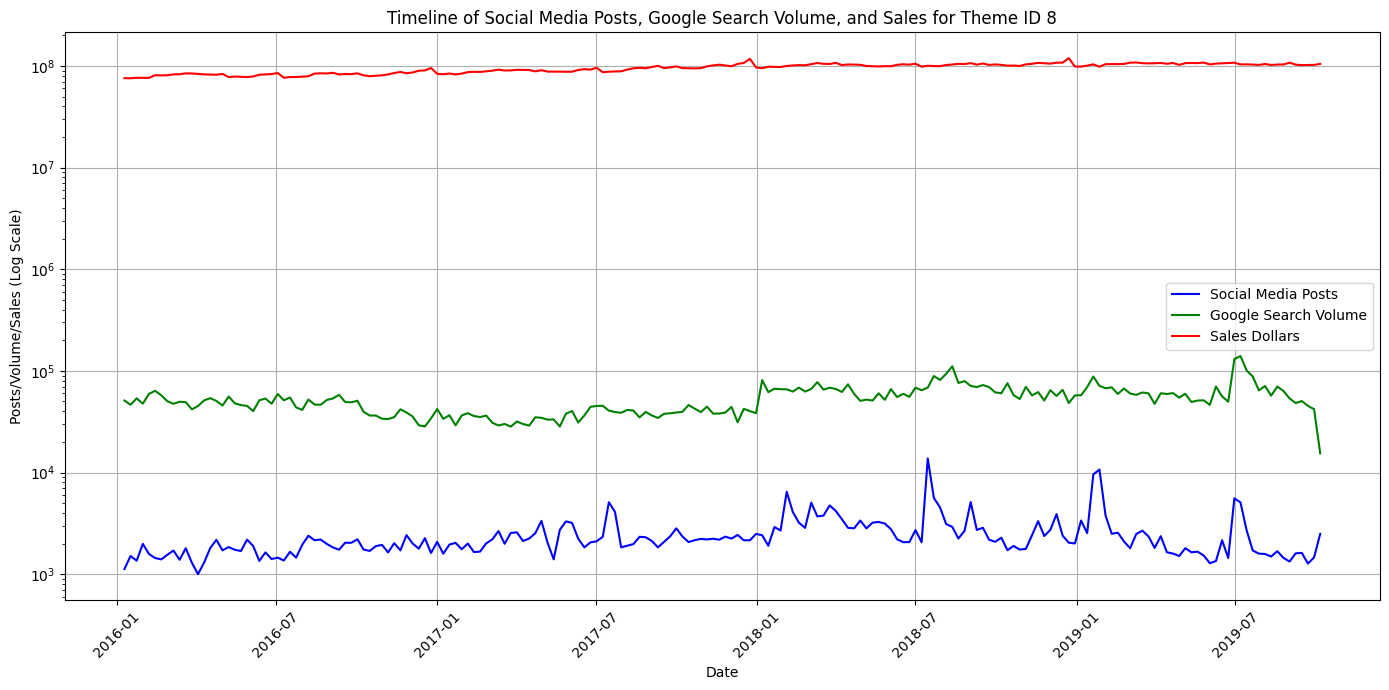

In [56]:
# Select a specific theme to visualize, e.g., theme_id 100 for "low calorie"
theme_id = 8
theme_data = merged_data[merged_data['theme_id'] == theme_id]

# Logarithmic Scaling for comparison
plt.figure(figsize=(14, 7))
plt.yscale('log')  # Set the y-axis to logarithmic scale

plt.plot(
    theme_data['social_media_date'],
    theme_data['total_post'],
    label='Social Media Posts',
    linestyle='-',
    color='blue'
)
plt.plot(
    theme_data['google_search_date'],
    theme_data['search_volume'],
    label='Google Search Volume',
    linestyle='-',
    color='green'
)
plt.plot(
    theme_data['sales_date'],
    theme_data['sales_dollars_value'],
    label='Sales Dollars',
    linestyle='-',
    color='red'
)

plt.title(f'Timeline of Social Media Posts, Google Search Volume, \
and Sales for Theme ID {theme_id}')
plt.xlabel('Date')
plt.ylabel('Posts/Volume/Sales (Log Scale)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

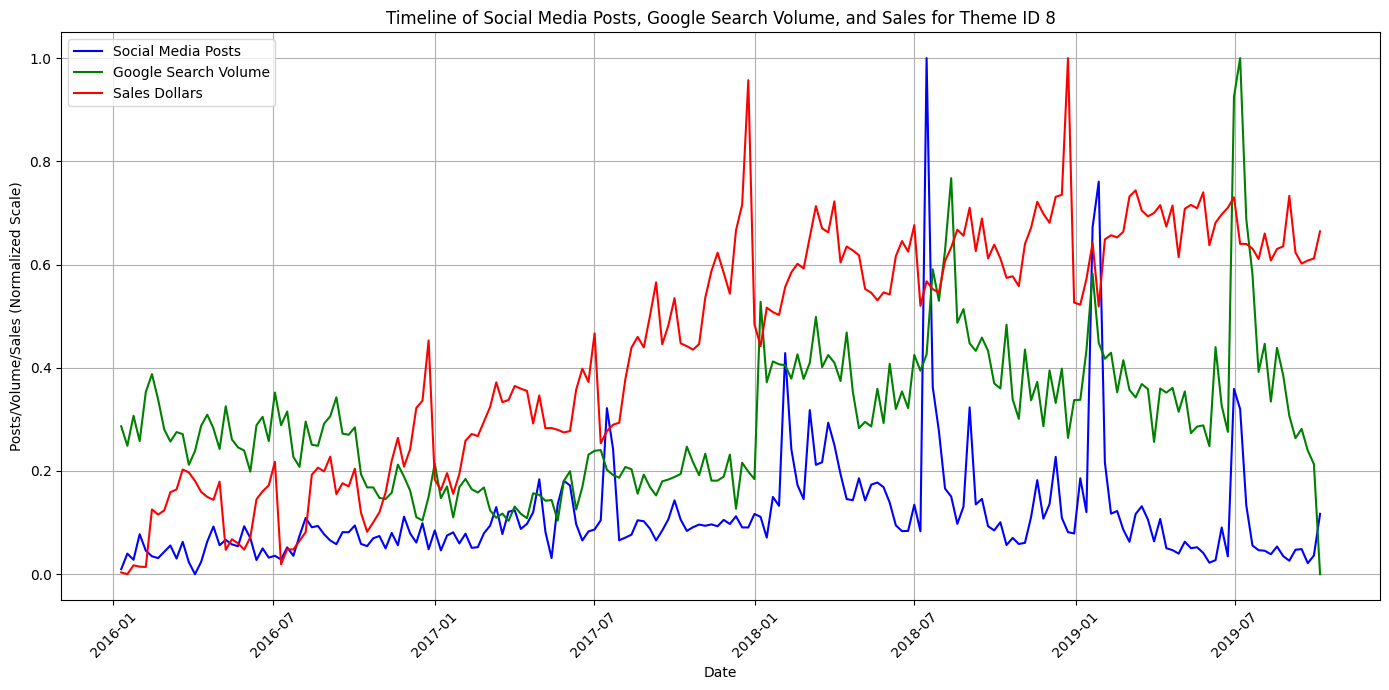

In [61]:
# Scaled Scales Plots
scaler = MinMaxScaler()
theme_data_scaled = scaler.fit_transform(theme_data[[
    'total_post',
    'search_volume',
    'sales_dollars_value'
]])
theme_data_scaled = pd.DataFrame(
    theme_data_scaled,
    columns=['total_post', 'search_volume', 'sales_dollars_value'],
    index=theme_data.index
)

plt.figure(figsize=(14, 7))
plt.plot(
    theme_data['social_media_date'],
    theme_data_scaled['total_post'],
    label='Social Media Posts',
    linestyle='-',
    color='blue'
)
plt.plot(
    theme_data['google_search_date'],
    theme_data_scaled['search_volume'],
    label='Google Search Volume',
    linestyle='-',
    color='green'
)
plt.plot(
    theme_data['sales_date'],
    theme_data_scaled['sales_dollars_value'],
    label='Sales Dollars',
    linestyle='-',
    color='red'
)

plt.title(f'Timeline of Social Media Posts, Google Search Volume, \
and Sales for Theme ID {theme_id}')
plt.xlabel('Date')
plt.ylabel('Posts/Volume/Sales (Normalized Scale)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**DEV NOTES**

<details>

- *Social Media Posts:* Less drastic fluctuations
- *Google Search Volume:* More drastic fluctuations
- *Sales Dollars Value:* Gradually increasing
- Some of the highest peaks in Sales correlate closely with peaks in Google search volume.
- The sales peaks often follow the search volume peaks, supporting the hypothesis that increases in search activity can lead to increased sales.
- The latency appears to be short, often just a part of a quarter, suggesting that once interest spikes, sales responses can be swift.

</details>

#### Emerging Trends - Analysis

In [ ]:
def calculate_moving_averages(
    weekly_data: pd.DataFrame,
    date_col_name: str,
    aggregation_col_name: str
) -> pd.DataFrame:

    week_as_index_df = weekly_data.set_index(date_col_name)

    # Calculate the rolling mean with a window size of 52 weeks
    # within each theme
    moving_averages = (
        week_as_index_df.groupby("theme_id")[aggregation_col_name]
                        .rolling(window=52)
                        .mean()
    )

    moving_averages = moving_averages.reset_index()

    moving_averages.rename(
        columns={aggregation_col_name: "moving_average"},
        inplace=True
    )

    return moving_averages

In [ ]:
def find_top_emerging_themes_in_weekly_data(
    weekly_data: pd.DataFrame,
    date_col_name: str,
    aggregation_col_name: str
    
) -> pd.DataFrame:
    """
    Function to find the top emerging themes in a provided data that is
    aggregated on a weekly basis 
    """

    # Get the moving averages dataframe from the weekly data
    moving_averages = calculate_moving_averages(
        weekly_data,
        date_col_name,
        aggregation_col_name
    )

    # Initialize a DataFrame to store the slope coefficients for each theme
    theme_slopes = pd.DataFrame(columns=['theme_id', 'slope'])
    # Iterate over each theme
    for theme_id in sorted(list(moving_averages.theme_id.unique())):
        theme_data = moving_averages[moving_averages.theme_id == theme_id]
        theme_data.drop("theme_id", axis=1, inplace=True)
        theme_data.set_index(date_col_name, inplace=True)
        theme_data.dropna(inplace=True)

        # If there is no data available (i.e., all values are null), skip
        if theme_data.shape[0] == 0:
            continue

        # Extract the sales date and moving average values
        # Convert dates to numeric values
        X = theme_data.index.factorize()[0].reshape(-1, 1)
        y = theme_data['moving_average'].values
        
        # Fit a linear regression model
        model = sm.OLS(y, sm.add_constant(X)).fit()
        
        # Extract the slope coefficient
        slope = model.params[1]

        # Append the theme_id and slope to the DataFrame
        theme_slopes = pd.concat([
            theme_slopes,
            pd.DataFrame({'theme_id': [theme_id], 'slope': [slope]})
        ], ignore_index=True)


    # Get the corresponding theme name as well
    theme_slopes = pd.merge(
        theme_slopes,
        theme_df,
        "left",
        "theme_id"
    )

    # Sort it in ascending order, reorder the columns, and reset the index
    # to indicate the rank
    theme_slopes = (
        theme_slopes.sort_values("slope", ascending=False)
                        [["theme_id", "theme_name", "slope"]]
                        .reset_index(drop=True)
    )

    return theme_slopes

In [ ]:
# Emerging themes for the sales data
find_top_emerging_themes_in_weekly_data(
    sales_weekly,
    "sales_date",
    "sales_units_value"
).head(20)

,theme_id,theme_name,slope
0,8,low carb,27916.300168
1,32,stroganoff,11470.644206
2,40,no additives/preservatives,8240.987914
3,81,gmo free,2427.872183
4,224,american southwest style,1977.181514
5,187,blueberry,1977.181514
6,58,buckwheat,1749.641515
7,186,pollock,1593.077418
8,158,chicken,1232.681025
9,75,french bisque,976.62637


In [ ]:
social_media_weekly.head(2)

,published_date,theme_id,total_post
0,2015-05-24,8.0,412
1,2015-05-24,15.0,4


In [ ]:
# Emerging themes for the social media data
find_top_emerging_themes_in_weekly_data(
    social_media_weekly,
    "published_date",
    "total_post"
).head(10)

,theme_id,theme_name,slope
0,770.0,rabbit,62.757229
1,668.0,probiotic,50.587849
2,732.0,pumpkin,42.619029
3,964.0,shrimp,40.860132
4,191.0,bone health,39.730503
5,622.0,cheese,36.974774
6,516.0,microwaveable,23.531344
7,876.0,caramel,23.223855
8,594.0,hfcs free,20.785538
9,747.0,dry,19.689971


In [ ]:
google_search_weekly.head(2)

,date,theme_id,search_volume
0,2014-01-05,8,30266
1,2014-01-05,39,272


In [ ]:
# Emerging themes for the google search data
find_top_emerging_themes_in_weekly_data(
    google_search_weekly,
    "date",
    "search_volume"
).head(10)

,theme_id,theme_name,slope
0,657,low gi,704.903572
1,576,health (passive),557.33512
2,980,honey,524.145716
3,613,sugar free,479.888955
4,670,boar,410.764558
5,964,shrimp,405.603828
6,869,ethical - environment,371.849021
7,634,garden pea,283.766051
8,151,low sodium,202.933758
9,668,probiotic,183.299128


#### Time Granularity

##### For Sales Data

In [ ]:
sales_with_vendor["purchase_date"] = (
    sales_with_vendor.system_calendar_key_n.apply(
        lambda n: f"{str(n)[: 4]}-{str(n)[4: 6]}-{str(n)[6: ]}"
    )
)

sales_with_vendor.sample(6, random_state=context.random_seed)

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,vendor,purchase_date
466375,20160409,42506,678.0,68,21,81,gmo free,Others,2016-04-09
3730689,20171202,46836,2425.0,193,772,186,pollock,Private Label,2017-12-02
6731893,20190413,52456,119.0,17,42,186,pollock,Private Label,2019-04-13
2021095,20170204,8364,2523.0,48,1442,227,salmon,D,2017-02-04
316193,20160312,18940,4691.0,253,1137,81,gmo free,F,2016-03-12
7170312,20190629,34551,909.0,699,44,0,No Claim,Others,2019-06-29


In [ ]:
sales_with_vendor.purchase_date = pd.to_datetime(
    sales_with_vendor.purchase_date
)

sales_with_vendor.purchase_date.info()

<class 'pandas.core.series.Series'>
Int64Index: 7767420 entries, 0 to 7767419
Series name: purchase_date
Non-Null Count    Dtype         
--------------    -----         
7767420 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 118.5 MB


In [ ]:
# Function to format y-axis ticks
def format_ticks(x, pos):
    """
    Args:
        x: tick value
        pos: position
    Returns:
        formatted tick value
    """
    return f"{x:,.0f}"

In [ ]:
def plot_time_analysis_graphs(
    dataframe: pd.DataFrame,
    date_variable: str,
    analysis_target: str,
) -> None:
    """
    Function to plot the time granularity graphs
    """

    time_analysis_df = dataframe.set_index(date_variable)

    # Yearly Analysis
    yearly_analysis = time_analysis_df.resample('Y').sum()

    # Monthly Analysis
    monthly_analysis = time_analysis_df.resample('M').sum()

    # Daily Analysis
    daily_analysis = time_analysis_df.resample('D').sum()

    # Weekly Analysis
    weekly_analysis = time_analysis_df.resample('W').sum()

    # Quarterly Analysis
    quarterly_analysis = time_analysis_df.resample('Q').sum()


    # Plotting
    plt.figure(figsize=(24, 14))

    # Yearly Analysis Plot
    plt.subplot(5, 1, 1)
    plt.plot(
        yearly_analysis.index.year,
        yearly_analysis[analysis_target],
        marker='o',
        linestyle='-'
    )
    plt.title(f'Yearly {analysis_target} Analysis')
    plt.xlabel('Year')
    plt.ylabel(analysis_target)
    plt.xticks(yearly_analysis.index.year)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.grid(True)

    # Monthly Analysis Plot
    plt.subplot(5, 1, 2)
    plt.plot(
        monthly_analysis.index,
        monthly_analysis[analysis_target],
        marker='o',
        linestyle='-'
    )
    plt.title(f'Monthly {analysis_target} Analysis')
    plt.xlabel('Month')
    plt.ylabel(analysis_target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.grid(True)

    # Daily Analysis Plot
    plt.subplot(5, 1, 3)
    plt.plot(
        daily_analysis.index,
        daily_analysis[analysis_target],
        marker='o',
        linestyle='-'
    )
    plt.title(f'Daily {analysis_target} Analysis')
    plt.xlabel('Date')
    plt.ylabel(analysis_target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.grid(True)

    # Weekly Analysis Plot
    plt.subplot(5, 1, 4)
    plt.plot(
        weekly_analysis.index,
        weekly_analysis[analysis_target],
        marker='o',
        linestyle='-'
    )
    plt.title(f'Weekly {analysis_target} Analysis')
    plt.xlabel('Week')
    plt.ylabel(analysis_target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.grid(True)

    # Quarterly Analysis Plot
    plt.subplot(5, 1, 5)
    plt.plot(
        quarterly_analysis.index,
        quarterly_analysis[analysis_target],
        marker='o',
        linestyle='-'
    )
    plt.title(f'Quarterly {analysis_target} Analysis')
    plt.xlabel('Quarter')
    plt.ylabel(analysis_target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.grid(True)

    plt.tight_layout()
    plt.show()

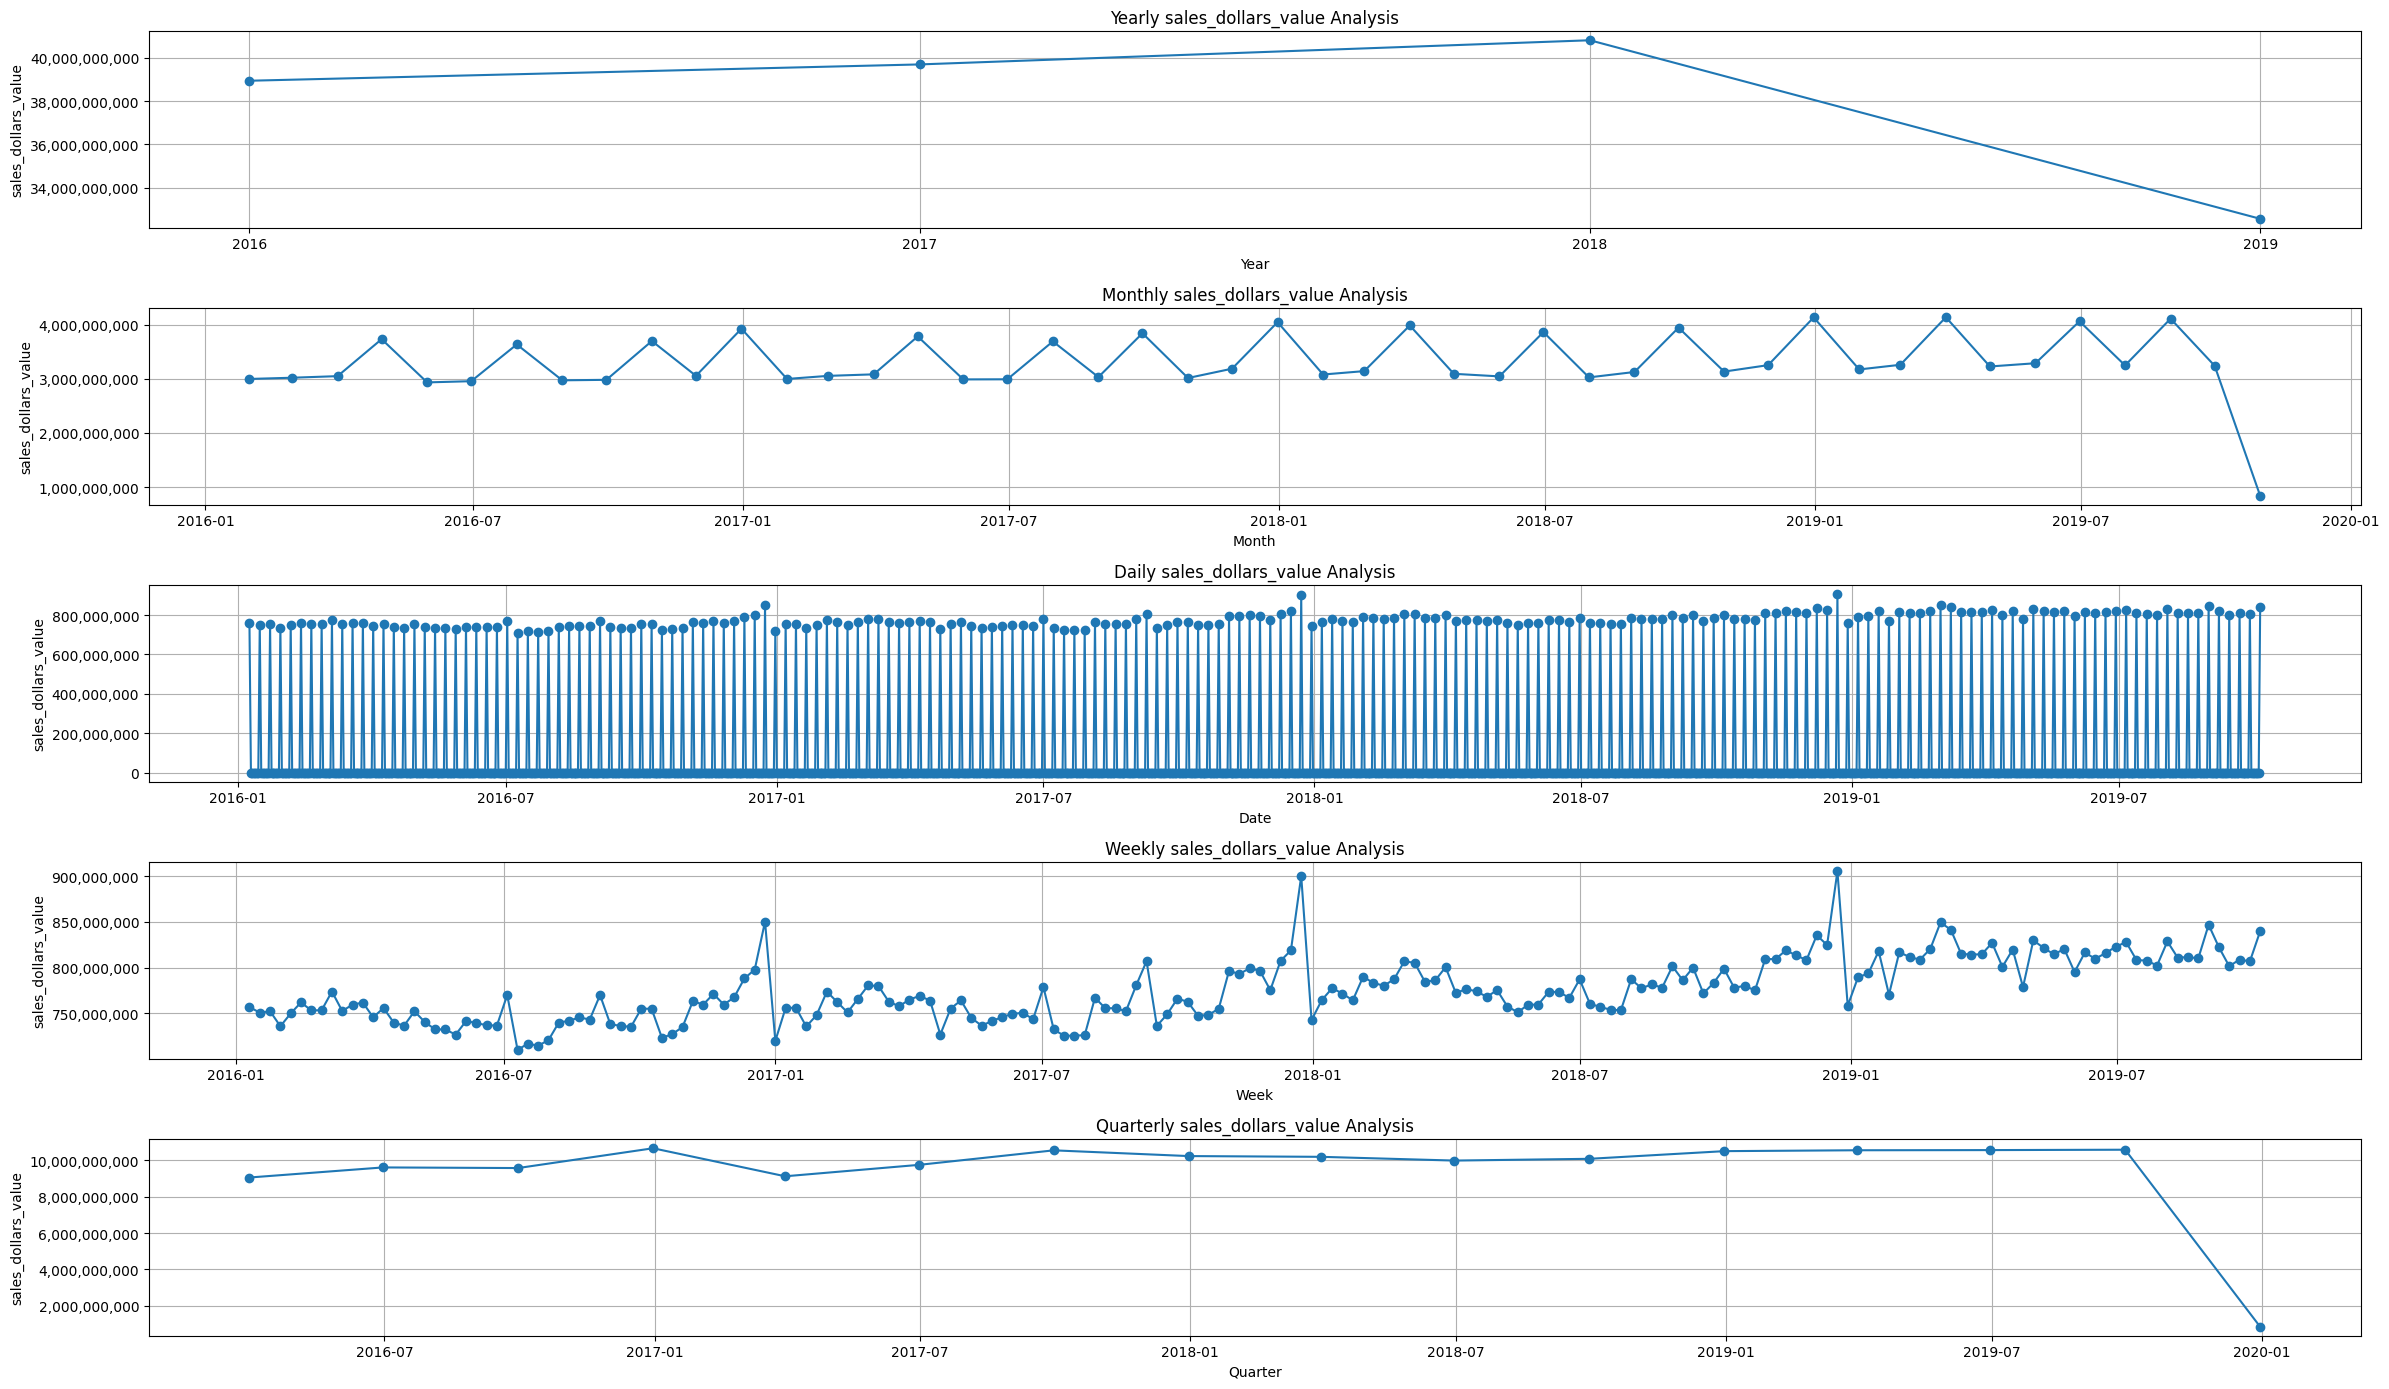

In [ ]:
plot_time_analysis_graphs(
    sales_with_vendor,
    "purchase_date",
    "sales_dollars_value"
)

##### For Social Media Data

In [ ]:
social_media_df.published_date = pd.to_datetime(social_media_df.published_date)

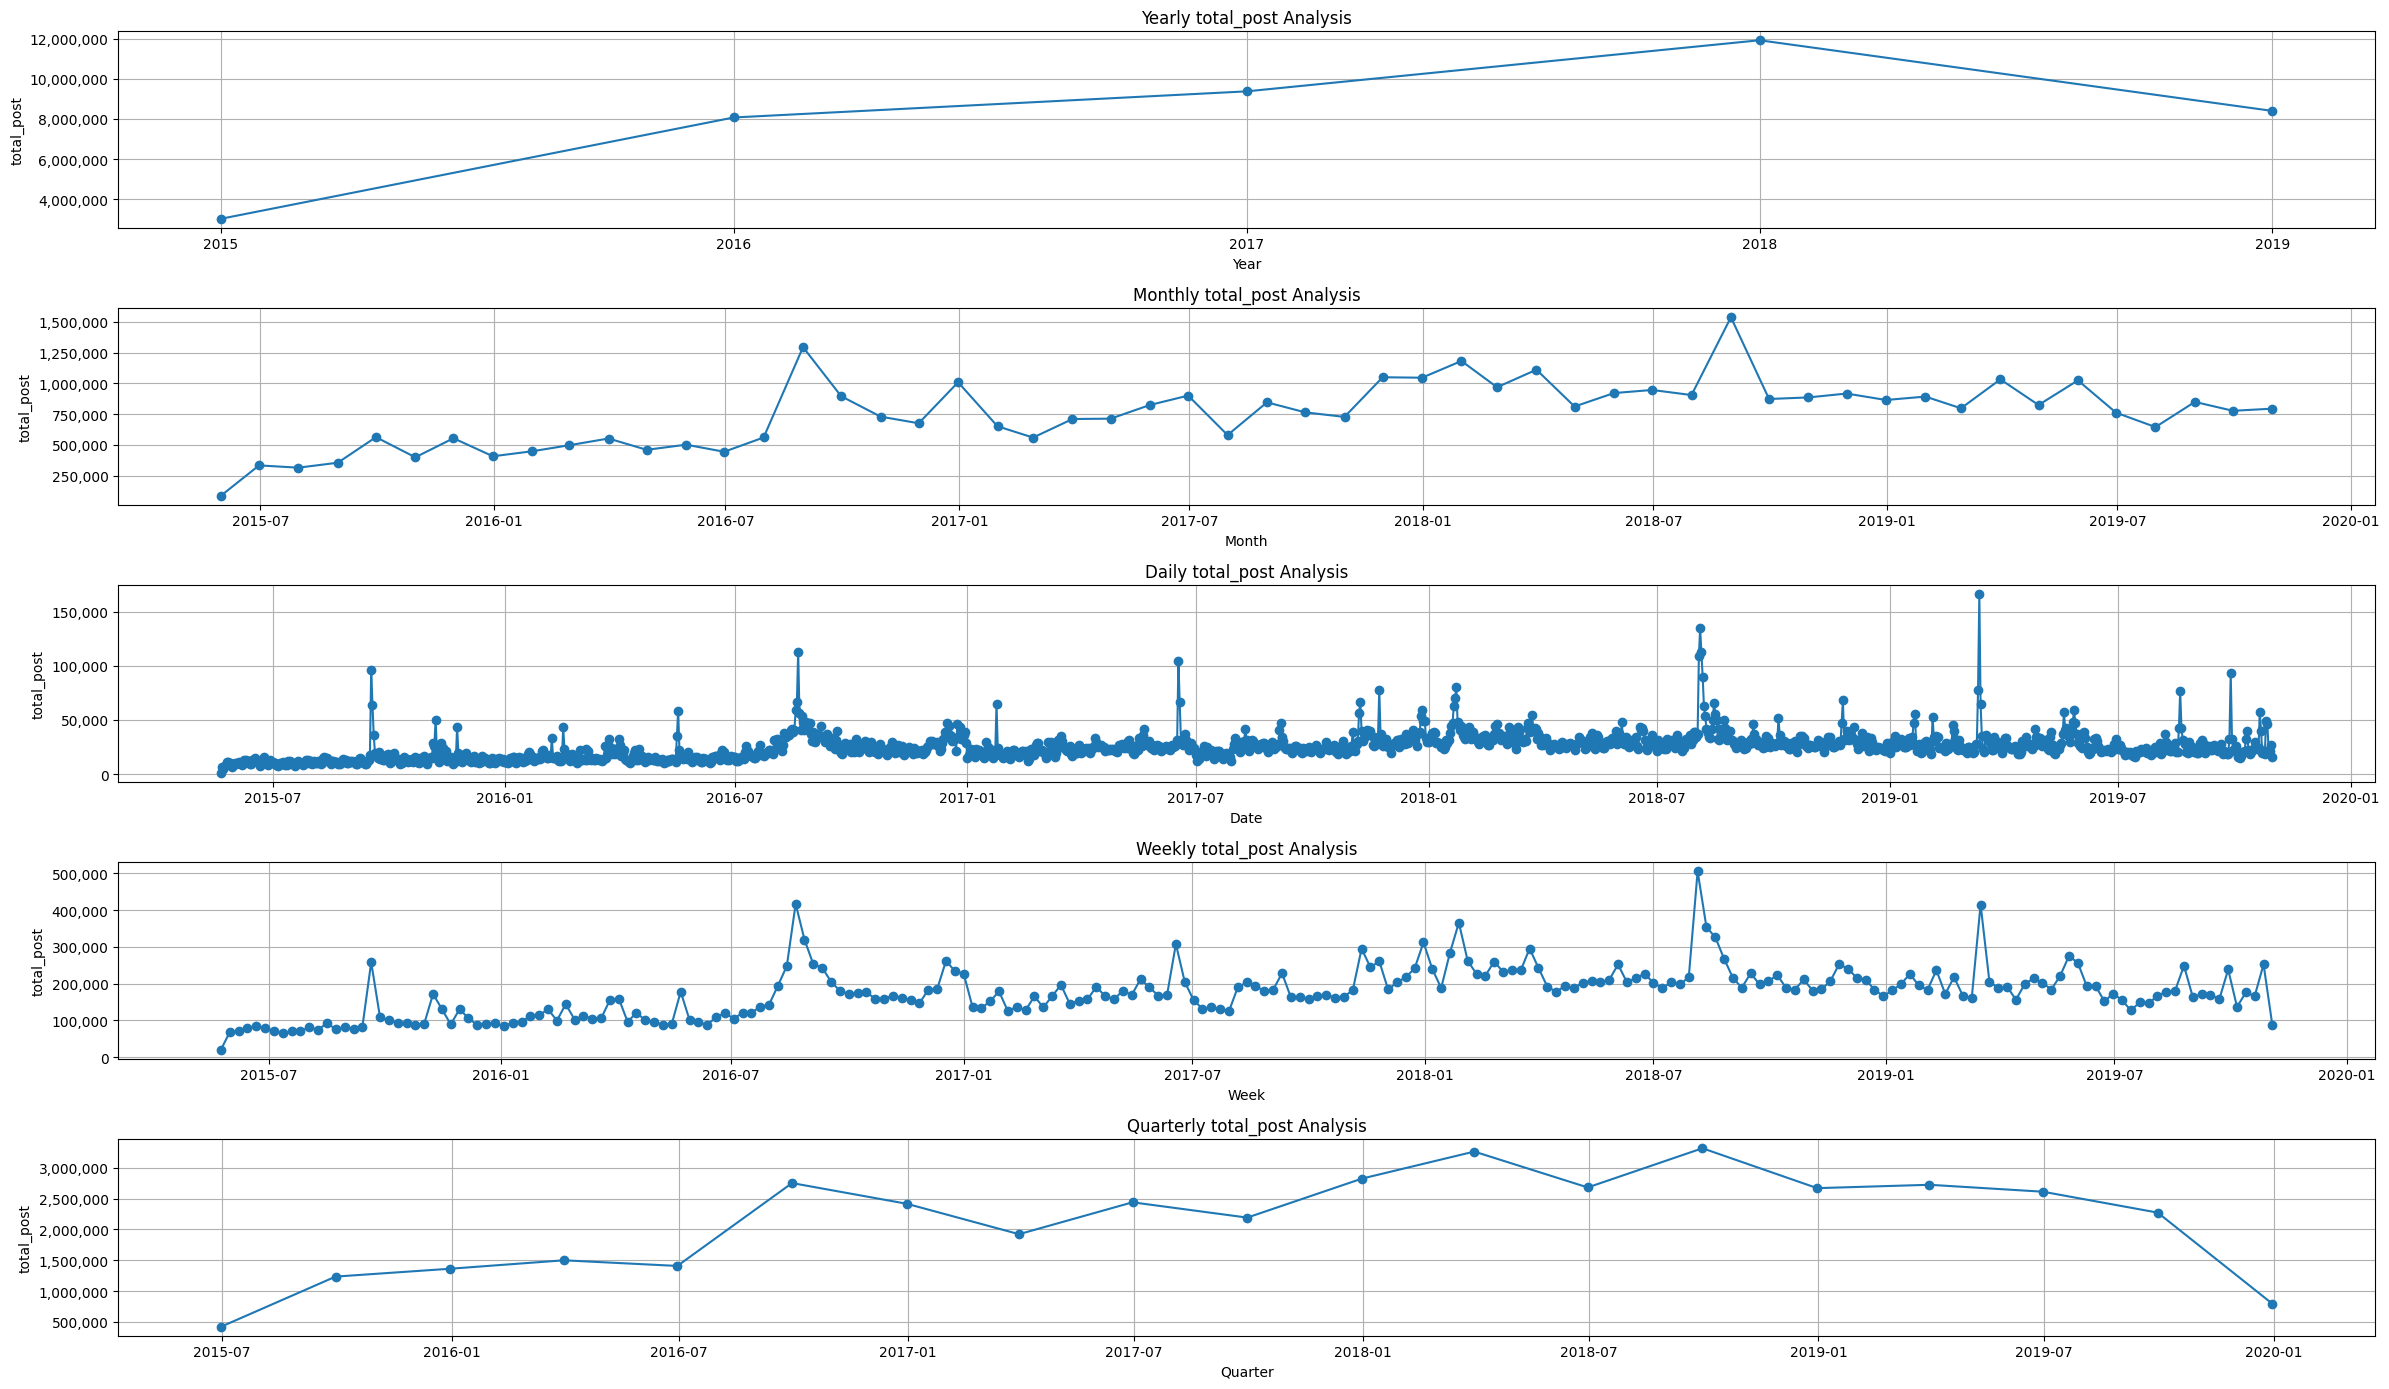

In [ ]:
plot_time_analysis_graphs(
    social_media_df,
    "published_date",
    "total_post"
)

##### For Google Search Data

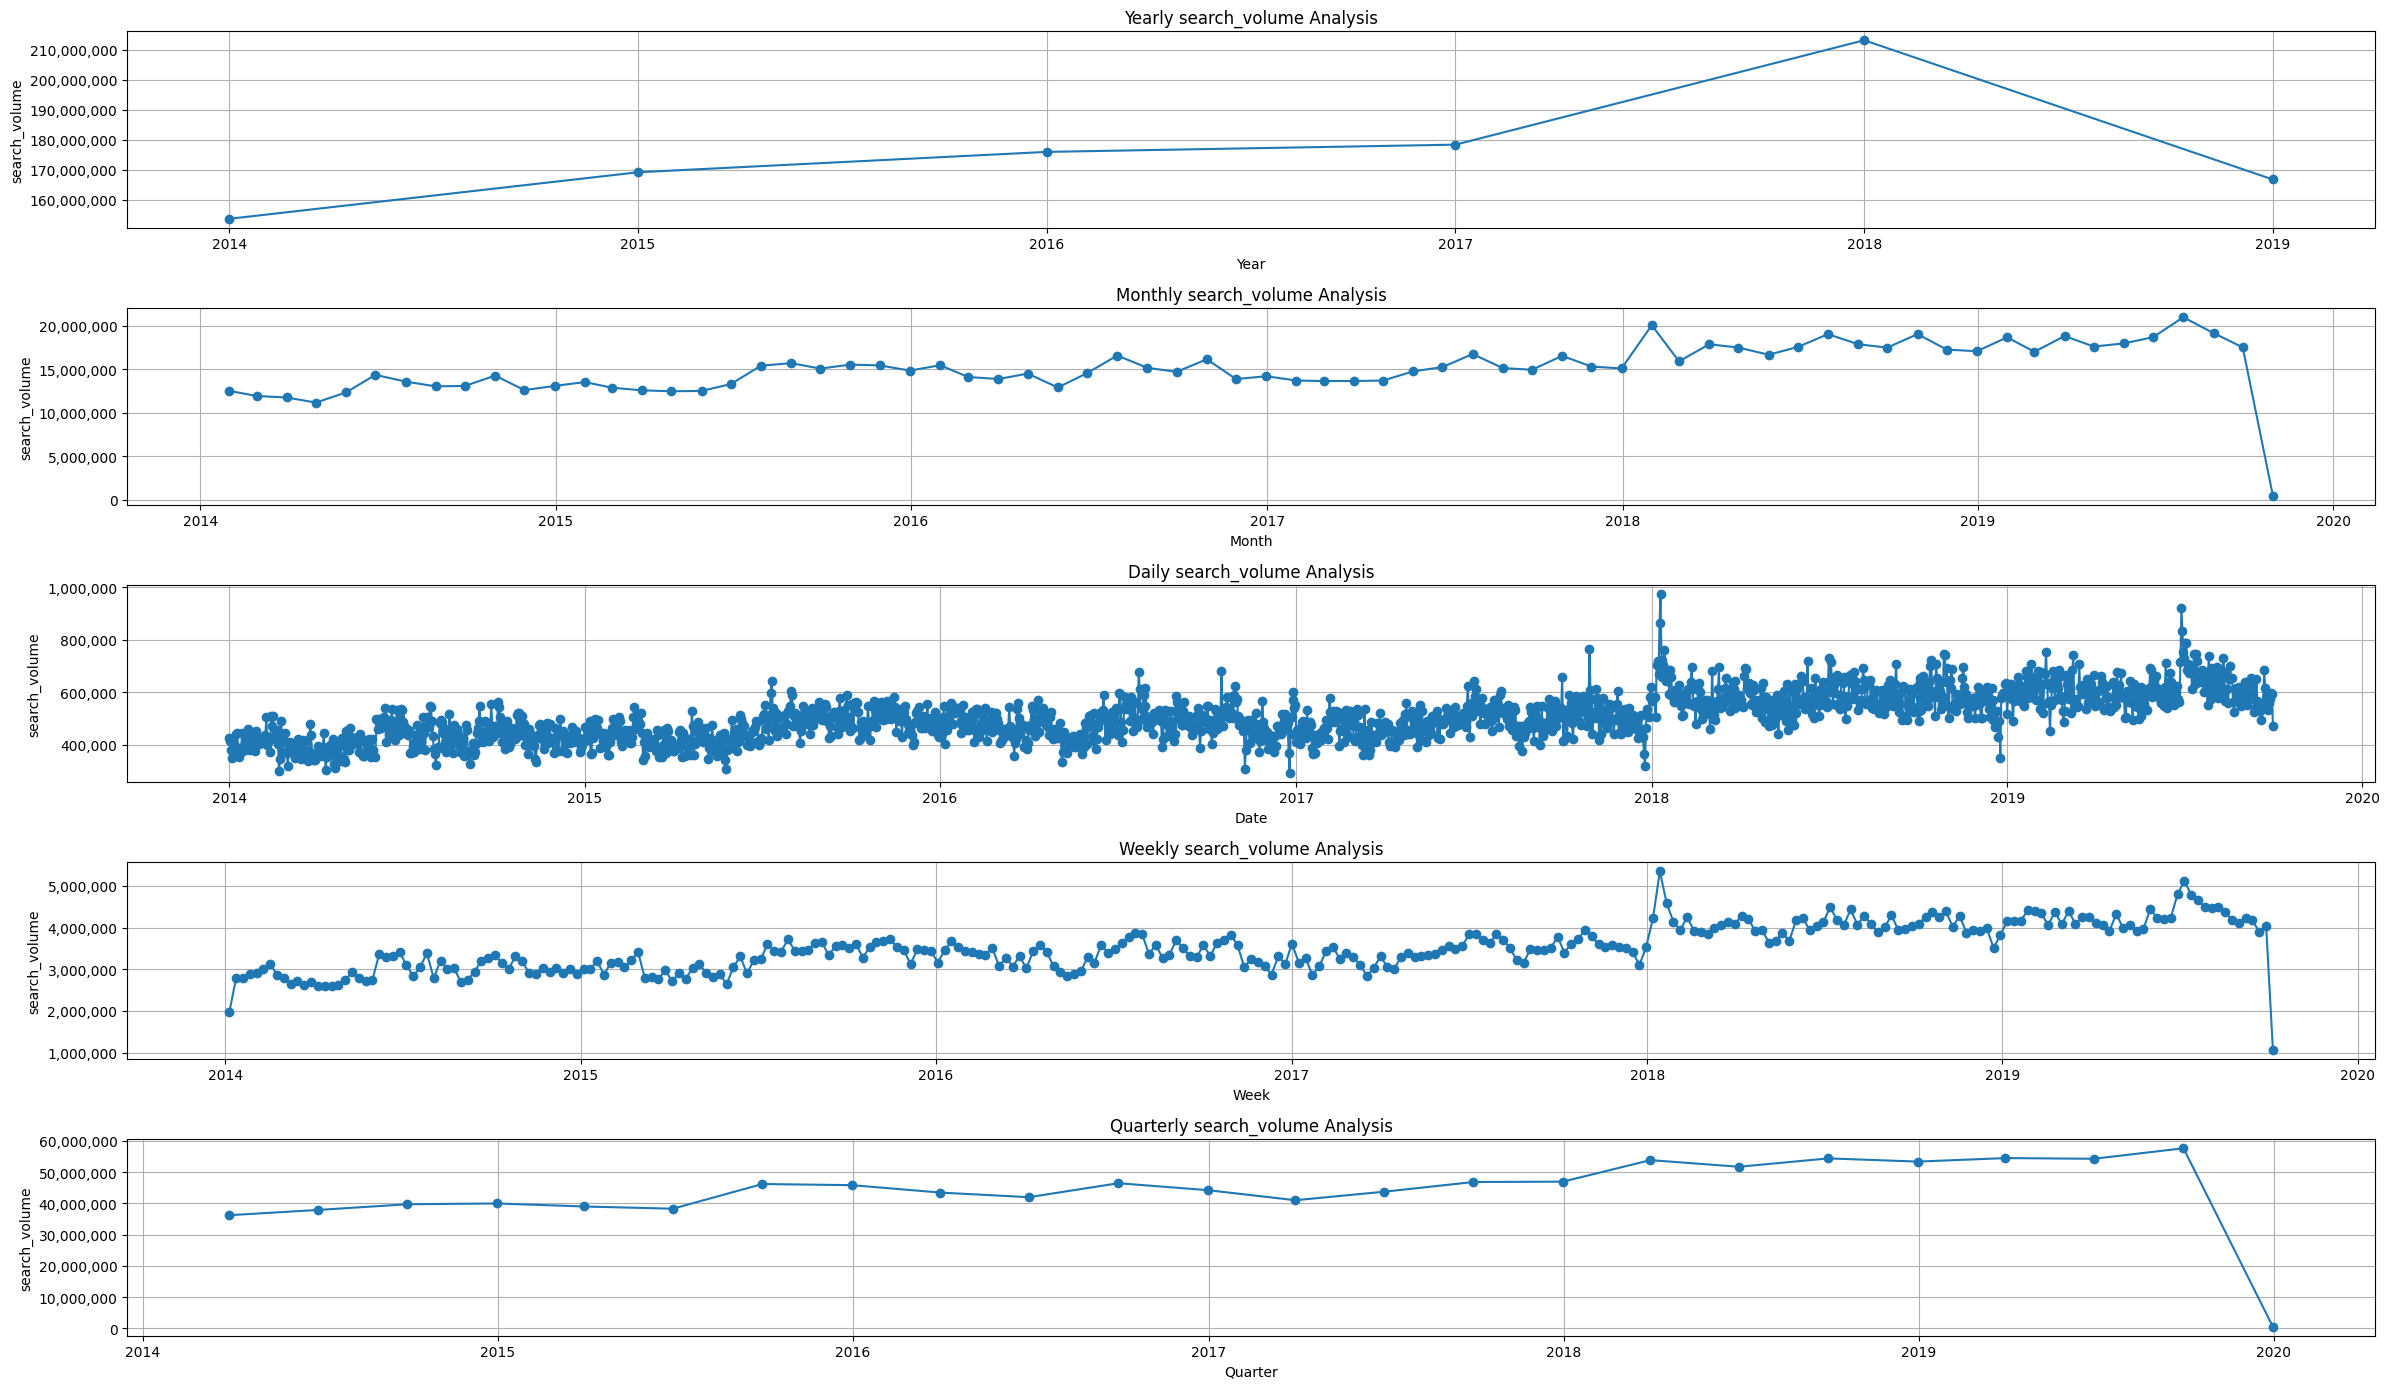

In [ ]:
plot_time_analysis_graphs(
    google_search_df,
    "date",
    "search_volume"
)

In [ ]:
sales_with_vendor

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,vendor,purchase_date
0,20160109,1,13927.0,934,18680,0,No Claim,Others,2016-01-09
1,20160109,3,10289.0,1592,28646,0,No Claim,Others,2016-01-09
2,20160109,4,357.0,22,440,0,No Claim,Others,2016-01-09
3,20160109,6,23113.0,2027,81088,0,No Claim,Others,2016-01-09
4,20160109,7,23177.0,3231,58164,0,No Claim,Others,2016-01-09
...,...,...,...,...,...,...,...,...,...
7767415,20181027,47539,391.0,39,68,0,No Claim,Private Label,2018-10-27
7767416,20181027,47543,105.0,59,48,227,salmon,Private Label,2018-10-27
7767417,20181027,47543,105.0,59,48,8,low carb,Private Label,2018-10-27
7767418,20181027,47544,3720.0,1246,4361,0,No Claim,Private Label,2018-10-27


### Create the Merged Dataset For Train-Test Split

In [187]:
google_search_df

,date,platform,search_volume,theme_id,week_number,year_new,theme_name
0,2014-01-05,google,349,916,1,2014,gluten free
1,2014-01-06,google,349,916,2,2014,gluten free
2,2014-01-07,google,697,916,2,2014,gluten free
3,2014-01-10,google,349,916,2,2014,gluten free
4,2014-01-20,google,697,916,4,2014,gluten free
...,...,...,...,...,...,...,...
181520,2019-09-05,walmart,125,980,36,2019,honey
181521,2019-09-22,walmart,84,980,38,2019,honey
181522,2019-09-26,walmart,42,980,39,2019,honey
181523,2019-07-15,walmart,42,622,29,2019,cheese


In [188]:
social_media_df_to_merge = (
    social_media_df.groupby("theme_id")["total_post"].sum().reset_index()
)

social_media_df_to_merge

,theme_id,total_post
0,8.0,535903
1,15.0,10259
2,26.0,331
3,38.0,6514
4,39.0,7122
...,...,...
188,982.0,97262
189,983.0,238672
190,984.0,41928
191,985.0,8602


In [189]:
google_search_df_to_merge = (
    google_search_df.groupby("theme_id")["search_volume"].sum().reset_index()
)

google_search_df_to_merge

,theme_id,search_volume
0,8,14911004
1,39,112339
2,40,2734
3,65,813054
4,75,3235011
...,...,...
155,981,646
156,982,25
157,984,74772
158,985,252


There are a total of 205 themes in total across all the datasets that we can't consider all. So, we need to check which ones are common across all the datasets.

In [190]:
common_themes_set = list(
    set(sales_with_vendor.theme_id.unique().tolist())
        & set(google_search_df.theme_id.unique().tolist())
        & set(social_media_df.theme_id.unique().tolist())
)

len(common_themes_set)

30

Keep only those rows which have the themes among the common list of themes.

In [191]:
filtered_sales_df = (
    sales_with_vendor[sales_with_vendor["theme_id"].isin(common_themes_set)]
)

filtered_sales_df.theme_id.nunique()

30

In [192]:
setanalyse(
    filtered_sales_df.theme_id.to_list(),
    google_search_df_to_merge.theme_id.to_list(),
)

{'A-B': 0, 'B-A': 130, 'AuB': 160, 'A^B': 30}

In [193]:
# Merge the the google search aggregated data
final_merged_df = pd.merge(
    filtered_sales_df,
    google_search_df_to_merge,
    "left",
    "theme_id"
)

final_merged_df.sample(6, random_state=context.random_seed)

,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,vendor,purchase_date,search_volume
3177852,26747,469.0,38,151,8,low carb,Others,2019-05-04,14911004
2108204,18915,734.0,19,207,151,low sodium,F,2018-05-05,8708056
2719365,23835,47018.0,1315,15786,40,no additives/preservatives,Others,2018-12-01,2734
828948,17948,730.0,85,42,151,low sodium,Others,2017-01-14,8708056
1493419,12499,96.0,81,28,40,no additives/preservatives,F,2017-09-30,2734
146313,19585,4771.0,103,1340,100,low calorie,Others,2016-03-19,1638926


In [194]:
setanalyse(
    final_merged_df.theme_id.to_list(),
    social_media_df_to_merge.theme_id.to_list(),
)

{'A-B': 0, 'B-A': 163, 'AuB': 193, 'A^B': 30}

In [195]:
# Merge the the google search aggregated data
final_merged_df = pd.merge(
    final_merged_df,
    social_media_df_to_merge,
    "left",
    "theme_id"
)

final_merged_df.sample(6, random_state=context.random_seed)

,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,vendor,purchase_date,search_volume,total_post
3177852,26747,469.0,38,151,8,low carb,Others,2019-05-04,14911004,535903
2108204,18915,734.0,19,207,151,low sodium,F,2018-05-05,8708056,121895
2719365,23835,47018.0,1315,15786,40,no additives/preservatives,Others,2018-12-01,2734,28035
828948,17948,730.0,85,42,151,low sodium,Others,2017-01-14,8708056,121895
1493419,12499,96.0,81,28,40,no additives/preservatives,F,2017-09-30,2734,28035
146313,19585,4771.0,103,1340,100,low calorie,Others,2016-03-19,1638926,16557


In [196]:
final_merged_df.theme_name.unique()

array(['chicken', 'salmon', 'soy foods', 'blueberry', 'poultry',
       'ethnic & exotic', 'no additives/preservatives', 'low carb',
       'gmo free', 'low sodium', 'french bisque', 'ethical - packaging',
       'crab', 'energy/alertness', 'low sugar', 'beef hamburger',
       'high/source of protein', 'gingerbread', 'vegetarian', 'prebiotic',
       'nuts', 'mackerel', 'low calorie', 'convenience - easy-to-prepare',
       'peach', 'sea salt', 'bone health', 'tuna', 'halal',
       'ethical - not specific'], dtype=object)

In [197]:
sales_with_vendor_A = sales_with_vendor[sales_with_vendor.vendor == "A"]

sales_with_vendor_A.drop(columns=["vendor"], inplace=True, axis=1)

sales_with_vendor_A

,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,theme_id,theme_name,purchase_date
78,587,156606.0,40400,161603,0,No Claim,2016-01-09
79,589,9126.0,365,18259,0,No Claim,2016-01-09
80,602,288682.0,95354,190707,0,No Claim,2016-01-09
81,608,130512.0,62462,62462,0,No Claim,2016-01-09
82,611,112.0,104,86,0,No Claim,2016-01-09
...,...,...,...,...,...,...,...
7762543,56582,2703.0,125,498,8,low carb,2019-10-05
7762544,56583,1742.0,39,468,8,low carb,2019-10-05
7762551,56592,649.0,18,289,0,No Claim,2019-10-05
7762643,56803,42.0,1,10,8,low carb,2019-10-05


In [198]:
sales_A_weekly = sales_with_vendor_A.groupby([
    pd.Grouper(key='purchase_date', freq='W'),
    'theme_id'
]).agg({
    'sales_dollars_value': 'sum',
    'sales_units_value': 'sum',
    'sales_lbs_value': 'sum',
    'theme_name': 'first'
}).reset_index()

sales_A_weekly.rename(columns={'purchase_date': 'sales_date'}, inplace=True)

In [199]:
final_merged_df = pd.merge(
    merged_data_mid,
    sales_A_weekly,
    how='inner',
    left_on=['google_search_date', 'theme_id'],
    right_on=['sales_date', 'theme_id']
)

final_merged_df

,social_media_date,theme_id,total_post,google_search_date,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value,theme_name
0,2016-01-10,8.0,1123,2016-01-10,51122,2016-01-10,8853853.0,1952575,2947044,low carb
1,2016-01-10,75.0,277,2016-01-10,13881,2016-01-10,40070.0,29471,8483,french bisque
2,2016-01-10,81.0,234,2016-01-10,6465,2016-01-10,129723.0,39825,91769,gmo free
3,2016-01-10,120.0,30,2016-01-10,1446,2016-01-10,21755.0,1487,5100,crab
4,2016-01-10,151.0,131,2016-01-10,13689,2016-01-10,198472.0,10494,106098,low sodium
...,...,...,...,...,...,...,...,...,...,...
2602,2019-10-06,227.0,176,2019-10-06,1600,2019-10-06,8554603.0,713185,5390433,salmon
2603,2019-10-06,228.0,122,2019-10-06,3044,2019-10-06,909.0,36,36,beef hamburger
2604,2019-10-06,430.0,32,2019-10-06,566,2019-10-06,5478214.0,1597839,3631126,soy foods
2605,2019-10-06,437.0,738,2019-10-06,5483,2019-10-06,1901.0,429,1716,vegetarian


In [200]:
final_merged_df.drop(
    columns=[
        "social_media_date",
        "google_search_date",
    ],
    inplace=True
)

#### Some More Cleaning to the Merged Data

Normalize the `theme_name` values (lowercase the strings and replace the spaces and other special characters with underscores, `_`).

In [201]:
final_merged_df.theme_name = final_merged_df.theme_name.apply(
    lambda name: (str(name).replace(" ", "_")
                           .replace("-", "_")
                           .replace("/", "_")
                           .replace("&", "_")
                           .replace("___", "_"))
)

final_merged_df.theme_name.unique(), final_merged_df.theme_name.nunique()

(array(['low_carb', 'french_bisque', 'gmo_free', 'crab', 'low_sodium',
        'low_sugar', 'chicken', 'blueberry', 'salmon', 'beef_hamburger',
        'soy_foods', 'ethnic_exotic', 'high_source_of_protein',
        'no_additives_preservatives', 'poultry', 'tuna', 'vegetarian',
        'ethical_packaging', 'gingerbread'], dtype=object),
 19)

### 1.2 Business Intuition Features

This section can go into production code if these features prove to be useful in the model training.

- **Competitors Count**  
    This will be the total number of competitors for each theme (only those themes which our client sells products in).

In [203]:
# Normalize the theme names of the ``competitor_list_per_theme`` dataframe
competitor_list_per_theme.theme_name = (
    competitor_list_per_theme.theme_name.apply(
        lambda name: (str(name).replace(" ", "_")
                            .replace("-", "_")
                            .replace("/", "_")
                            .replace("&", "_")
                            .replace("___", "_"))
    )
)

competitor_list_per_theme.theme_name.unique(), \
    competitor_list_per_theme.theme_name.nunique()

(array(['low_carb', 'stroganoff', 'high_source_of_protein',
        'no_additives_preservatives', 'buckwheat', 'brown_ale',
        'french_bisque', 'gmo_free', 'crab', 'american_gumbo', 'tuna',
        'low_sodium', 'low_sugar', 'chicken', 'ethical_packaging',
        'red_raspberry', 'cookie', 'pollock', 'blueberry', 'poultry',
        'herbs', 'pizza', 'american_southwest_style', 'salmon', 'tilapia',
        'soy_foods', 'apple_cinnamon', 'gingerbread', 'vegetarian',
        'ethnic_exotic'], dtype=object),
 30)

In [211]:
# Since, this particular theme has only "Others" and "A" as the competitors
# We had not considered "Others" and kept the threshold as 0.05 ("A" has less
# than 0.05 market share in this particular theme)
# So, we are adding a row to the dataframe with only "A" as the compititor
# for smooth merging of the datasets
competitor_list_per_theme_temp = pd.concat([
    competitor_list_per_theme,
    pd.DataFrame({
        "theme_id": [228.0],
        "theme_name": ["beef_hamburger"],
        "competitor_list": [["A"]],
    })
], ignore_index=True)

competitor_list_per_theme_temp[competitor_list_per_theme_temp.theme_id == 228]

,theme_id,theme_name,competitor_list
30,228.0,beef_hamburger,[A]


In [212]:
setanalyse(
    final_merged_df.theme_id.to_list(),
    competitor_list_per_theme_temp.theme_id.to_list(),
)

{'A-B': 0, 'B-A': 12, 'AuB': 31, 'A^B': 19}

In [215]:
final_merged_df = pd.merge(
    final_merged_df,
    competitor_list_per_theme_temp,
    "left",
    ["theme_id", "theme_name"]
)

final_merged_df

,theme_id,total_post,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value,theme_name,competitor_list
0,8.0,1123,51122,2016-01-10,8853853.0,1952575,2947044,low_carb,"[F, A, D, Private Label]"
1,75.0,277,13881,2016-01-10,40070.0,29471,8483,french_bisque,"[D, B]"
2,81.0,234,6465,2016-01-10,129723.0,39825,91769,gmo_free,[F]
3,120.0,30,1446,2016-01-10,21755.0,1487,5100,crab,[F]
4,151.0,131,13689,2016-01-10,198472.0,10494,106098,low_sodium,"[A, B]"
...,...,...,...,...,...,...,...,...,...
2602,227.0,176,1600,2019-10-06,8554603.0,713185,5390433,salmon,"[A, D, Private Label]"
2603,228.0,122,3044,2019-10-06,909.0,36,36,beef_hamburger,[A]
2604,430.0,32,566,2019-10-06,5478214.0,1597839,3631126,soy_foods,"[A, B, H, D, F]"
2605,437.0,738,5483,2019-10-06,1901.0,429,1716,vegetarian,[B]


Now, to count the number of competitors, we won't count our client itself.

In [217]:
final_merged_df["competitors_count"] = final_merged_df.competitor_list.apply(
    lambda comp_list: (len(comp_list) - 1) if "A" in comp_list \
                                            else len(comp_list)
)

final_merged_df.head()

,theme_id,total_post,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value,theme_name,competitor_list,competitors_count
0,8.0,1123,51122,2016-01-10,8853853.0,1952575,2947044,low_carb,"[F, A, D, Private Label]",3
1,75.0,277,13881,2016-01-10,40070.0,29471,8483,french_bisque,"[D, B]",2
2,81.0,234,6465,2016-01-10,129723.0,39825,91769,gmo_free,[F],1
3,120.0,30,1446,2016-01-10,21755.0,1487,5100,crab,[F],1
4,151.0,131,13689,2016-01-10,198472.0,10494,106098,low_sodium,"[A, B]",1


- **Unit Price of Each Product**  
    This will be the `sales_dollars_value` divided by the `sales_units_value`, i.e., the selling price of each product.

In [218]:
final_merged_df["product_unit_price"] = (
    final_merged_df.sales_dollars_value / final_merged_df.sales_units_value
)

final_merged_df.head()

,theme_id,total_post,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value,theme_name,competitor_list,competitors_count,product_unit_price
0,8.0,1123,51122,2016-01-10,8853853.0,1952575,2947044,low_carb,"[F, A, D, Private Label]",3,4.534450
1,75.0,277,13881,2016-01-10,40070.0,29471,8483,french_bisque,"[D, B]",2,1.359642
2,81.0,234,6465,2016-01-10,129723.0,39825,91769,gmo_free,[F],1,3.257326
3,120.0,30,1446,2016-01-10,21755.0,1487,5100,crab,[F],1,14.630128
4,151.0,131,13689,2016-01-10,198472.0,10494,106098,low_sodium,"[A, B]",1,18.912903


### 1.3 Display Final Summary of the Processed Dataset

In [219]:
final_df = final_merged_df.copy()

final_df

,theme_id,total_post,search_volume,sales_date,sales_dollars_value,sales_units_value,sales_lbs_value,theme_name,competitor_list,competitors_count,product_unit_price
0,8.0,1123,51122,2016-01-10,8853853.0,1952575,2947044,low_carb,"[F, A, D, Private Label]",3,4.534450
1,75.0,277,13881,2016-01-10,40070.0,29471,8483,french_bisque,"[D, B]",2,1.359642
2,81.0,234,6465,2016-01-10,129723.0,39825,91769,gmo_free,[F],1,3.257326
3,120.0,30,1446,2016-01-10,21755.0,1487,5100,crab,[F],1,14.630128
4,151.0,131,13689,2016-01-10,198472.0,10494,106098,low_sodium,"[A, B]",1,18.912903
...,...,...,...,...,...,...,...,...,...,...,...
2602,227.0,176,1600,2019-10-06,8554603.0,713185,5390433,salmon,"[A, D, Private Label]",2,11.994928
2603,228.0,122,3044,2019-10-06,909.0,36,36,beef_hamburger,[A],0,25.250000
2604,430.0,32,566,2019-10-06,5478214.0,1597839,3631126,soy_foods,"[A, B, H, D, F]",4,3.428514
2605,437.0,738,5483,2019-10-06,1901.0,429,1716,vegetarian,[B],1,4.431235


In [221]:
final_df = final_merged_df.copy()

display_as_tabs([
    (
        "Summary",
        f"Length: {len(final_df)}, Columns: {len(final_df.columns)}"
    ),

    (
        "Variable Summary",
        # Drop ``competitors_list`` column as it is unhashable
        eda.get_variable_summary(final_df.drop(columns=["competitor_list"]))
    ),
    ("Head", final_df.head(5).T),
    ("Tail", final_df.tail(5).T),
    ("Random Sample", final_df.sample(5).T),
])

Tabs
    [0] Markdown(str, name='Summary')
    [1] DataFrame(height=300, name='Variable Summary', sizing_mode='fixed', value=                          ..., width=800)
    [2] DataFrame(height=300, name='Head', sizing_mode='fixed', value=                          ..., width=800)
    [3] DataFrame(height=300, name='Tail', sizing_mode='fixed', value=                          ..., width=800)
    [4] DataFrame(height=300, name='Random Sample', sizing_mode='fixed', value=                          ..., width=800)

In [222]:
save_dataset(context, final_df, 'cleaned/final_cleaned_merged_data')

## 2. Generate Train, Validation, and Test Datasets

- We split the data into *train*, *test* (optionally, also a *validation* dataset)
- We shall bin the `sales_dollars_value` into 10 quantiles and then use a `Stratified Shuffle` to split the data.

**NOTE:** This will go into production code (training only)

In [223]:
final_df = load_dataset(context, "cleaned/final_cleaned_merged_data")

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2607 entries, 0 to 2606
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   theme_id             2607 non-null   float64       
 1   total_post           2607 non-null   int64         
 2   search_volume        2607 non-null   int64         
 3   sales_date           2607 non-null   datetime64[ns]
 4   sales_dollars_value  2607 non-null   float64       
 5   sales_units_value    2607 non-null   int64         
 6   sales_lbs_value      2607 non-null   int64         
 7   theme_name           2607 non-null   object        
 8   competitor_list      2607 non-null   object        
 9   competitors_count    2607 non-null   int64         
 10  product_unit_price   2607 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 244.4+ KB


### 2.1 Stratified Split of the Whole Data

In [224]:
def binned_sales_units_value(dataframe: pd.DataFrame) -> pd.Categorical:
    """Bin the ``sales_units_value`` column using quantiles."""

    return pd.qcut(dataframe["sales_units_value"], q=10)

In [225]:
splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=context.random_seed
)

splitter

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)

In [226]:
train_df, test_df = custom_train_test_split(
    final_df.reset_index(drop=True),  # to avoid indexing errors (KeyError)
    splitter,
    by=binned_sales_units_value
)

train_df.shape, test_df.shape

((2085, 11), (522, 11))

### 2.2 Split the Train and Test Data into Features and Target

In [227]:
target_col = "sales_units_value"

In [228]:
# Split the dataset to X and y variables
X_train, y_train = (
    train_df
    .get_features_targets(target_column_names=target_col)
)

X_train.shape, y_train.shape

((2085, 10), (2085,))

In [229]:
# Save the datasets
save_dataset(context, X_train, 'train/sales/features')
save_dataset(context, y_train, 'train/sales/target')

In [230]:
X_test, y_test = (
    test_df
    .get_features_targets(target_column_names=target_col)
)

X_test.shape, y_test.shape

((522, 10), (522,))

In [231]:
save_dataset(context, X_test, 'test/sales/features')
save_dataset(context, y_test, 'test/sales/target')

## <p align="center">The End</p>

---